In [1]:
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import json
import cv2
import os
import sys
sys.path.append('../utils')
os.chdir('../centermask2/')

from train_eval import Evaluation

root_directory = Path("../data")
images_directory = root_directory / "images"
annots_directory =  root_directory / "annotations"
bbox_directory =  root_directory / "annotations-bbox"
masks_directory =  root_directory / "annotations-seg"

<ipython-input-1-220d38e5722a>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Register Datasets

In [2]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog

path_to_train = annots_directory / 'modanet_instance_segmentation_train.json'
path_to_test = annots_directory / 'modanet_instance_segmentation_test.json'

register_coco_instances('modanet_instance_segmentation_train', {}, path_to_train, images_directory)
register_coco_instances('modanet_instance_segmentation_test', {}, path_to_test, images_directory)

MetadataCatalog.get('modanet_instance_segmentation_train').set(
    thing_classes=['bag', 'dress', 'footwear', 'skirt', 'top', 'sunglasses', \
                   'headwear', 'shorts', 'pants', 'belt', 'outer', 'scarf', 'boots']
)
train_metadata = MetadataCatalog.get('modanet_instance_segmentation_train')

[08/13 13:49:25 d2.data.datasets.coco]: Loading ../data/annotations/modanet_instance_segmentation_train.json takes 2.31 seconds.
[08/13 13:49:25 d2.data.datasets.coco]: Loaded 41803 images in COCO format from ../data/annotations/modanet_instance_segmentation_train.json


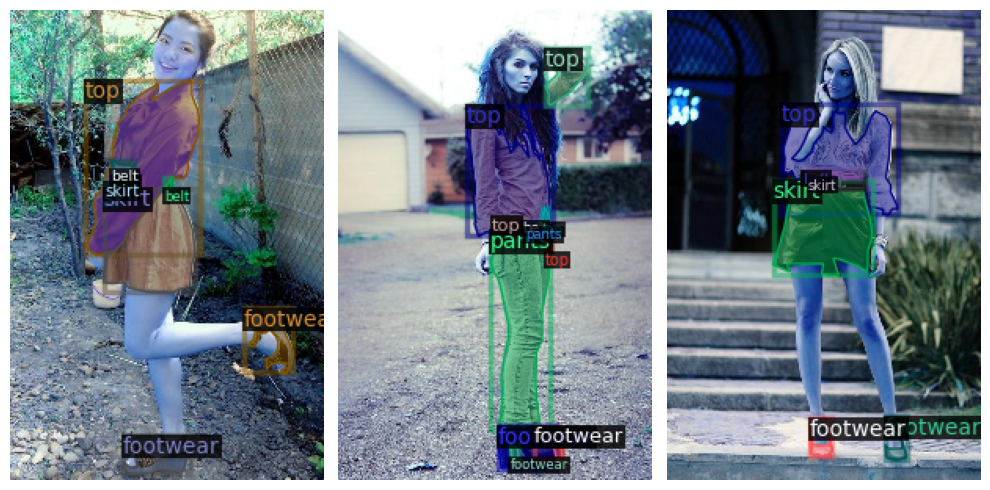

In [4]:
from detectron2.data.datasets import load_coco_json
dataset_dicts = load_coco_json("../data/annotations/modanet_instance_segmentation_train.json", "../data/images/")

f = Evaluation._show_n(dataset_dicts, train_metadata, predictions=False)

## CenterMask

### Training

In [6]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# from detectron2.config import get_cfg
from detectron2 import model_zoo

import random
random.seed(600)

from centermask.config import get_cfg

centermask_path = "configs/"
model_yaml_path = 'centermask/centermask_V_57_eSE_dcn_FPN_ms_3x.yaml'

# model_weights_path = 'detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl'

cfg = get_cfg()
cfg.merge_from_file(os.path.join(centermask_path, model_yaml_path))
cfg.OUTPUT_DIR = '../logs/centermask'
cfg.DATASETS.TRAIN = ('modanet_instance_segmentation_train',)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.01

cfg.SOLVER.NUM_GPUS = 1
single_iteration = cfg.SOLVER.NUM_GPUS * cfg.SOLVER.IMS_PER_BATCH
iterations_for_one_epoch = len(dataset_dicts) / single_iteration
cfg.SOLVER.MAX_ITER = iterations_for_one_epoch * 2 # -> 2 epochs?   

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_yaml_path)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

WARNING [08/13 13:50:49 d2.config.compat]: Config 'configs/centermask/centermask_V_57_eSE_dcn_FPN_ms_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [9]:
!wget https://dl.dropbox.com/s/1f64azqyd2ot6qq/centermask-V-57-eSE-dcn-FPN-ms-3x.pth

--2021-08-13 13:51:44--  https://dl.dropbox.com/s/1f64azqyd2ot6qq/centermask-V-57-eSE-dcn-FPN-ms-3x.pth
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.5.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/s/1f64azqyd2ot6qq/centermask-V-57-eSE-dcn-FPN-ms-3x.pth [following]
--2021-08-13 13:51:45--  https://dl.dropboxusercontent.com/s/1f64azqyd2ot6qq/centermask-V-57-eSE-dcn-FPN-ms-3x.pth
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.5.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 575282789 (549M) [application/octet-stream]
Saving to: ‘centermask-V-57-eSE-dcn-FPN-ms-3x.pth’

centermask-V-57-eSE 100%[============

In [10]:
!wget https://dl.dropbox.com/s/zmps03vghzirk7v/centermask-V-39-eSE-dcn-FPN-ms-3x.pth

--2021-08-13 13:59:59--  https://dl.dropbox.com/s/zmps03vghzirk7v/centermask-V-39-eSE-dcn-FPN-ms-3x.pth
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.5.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/s/zmps03vghzirk7v/centermask-V-39-eSE-dcn-FPN-ms-3x.pth [following]
--2021-08-13 14:00:00--  https://dl.dropboxusercontent.com/s/zmps03vghzirk7v/centermask-V-39-eSE-dcn-FPN-ms-3x.pth
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.5.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 435361246 (415M) [application/octet-stream]
Saving to: ‘centermask-V-39-eSE-dcn-FPN-ms-3x.pth’

centermask-V-39-eSE 100%[============

In [7]:
cfg.MODEL.WEIGHTS

'https://www.dropbox.com/s/8xl0cb3jj51f45a/vovnet57_ese_detectron2.pth?dl=1'

In [ ]:
cfg.SOLVER.AMP.ENABLED = True
cfg.CUDNN_BENCHMARK = True
cfg.SOLVER.MAX_ITER, cfg.SOLVER.STEPS, cfg.SOLVER.BASE_LR, cfg.SOLVER.WEIGHT_DECAY

In [ ]:
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.MAX_ITER = 700
cfg.SOLVER.BASE_LR = 0.03
cfg.SOLVER.STEPS = (500, 600)

In [9]:
# from detectron2.engine import DefaultTrainer

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

In [11]:
!python train_net.py --num-gpus 1 --config-file configs/centermask/centermask_V_57_eSE_dcn_FPN_ms_3x.yaml

Command Line Args: Namespace(config_file='configs/centermask/centermask_V_57_eSE_dcn_FPN_ms_3x.yaml', dist_url='tcp://127.0.0.1:50152', eval_only=False, machine_rank=0, num_gpus=1, num_machines=1, opts=[], resume=False)
Config 'configs/centermask/centermask_V_57_eSE_dcn_FPN_ms_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[08/13 13:38:51 detectron2]: Rank of current process: 0. World size: 1
[08/13 13:38:51 detectron2]: Environment info:
----------------------  ---------------------------------------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.11 (default, Aug  3 2021, 15:09:35) [GCC 7.5.0]
numpy                   1.20.3
detectron2              0.5 @/opt/miniconda3/envs/vision/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   /opt/miniconda3/envs/vision/lib/python3.8/site-packages/detectr

[08/13 13:38:51 d2.utils.env]: Using a generated random seed 54078924
[08/13 13:38:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): VoVNet(
      (stem): Sequential(
        (stem_1/conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (stem_1/norm): 

Traceback (most recent call last):
  File "train_net.py", line 150, in <module>
    launch(
  File "/opt/miniconda3/envs/vision/lib/python3.8/site-packages/detectron2/engine/launch.py", line 82, in launch
    main_func(*args)
  File "train_net.py", line 138, in main
    trainer = Trainer(cfg)
  File "/opt/miniconda3/envs/vision/lib/python3.8/site-packages/detectron2/engine/defaults.py", line 381, in __init__
    data_loader = self.build_train_loader(cfg)
  File "/opt/miniconda3/envs/vision/lib/python3.8/site-packages/detectron2/engine/defaults.py", line 541, in build_train_loader
    return build_detection_train_loader(cfg)
  File "/opt/miniconda3/envs/vision/lib/python3.8/site-packages/detectron2/config/config.py", line 192, in wrapped
    explicit_args = _get_args_from_config(from_config, *args, **kwargs)
  File "/opt/miniconda3/envs/vision/lib/python3.8/site-packages/detectron2/config/config.py", line 229, in _get_args_from_config
    ret = from_config_func(*args, **kwargs)
  File "

### Evaluate

In [16]:
eval_tools = Evaluation(cfg, "modanet_instance_segmentation_test")

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (14, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (14,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (52, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (52,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (13, 256, 1, 

In [17]:
# eval_tools.run_coco_eval()

### Visualizations

In [18]:
# from detectron2.engine import DefaultPredictor

# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
# cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.4 # original 0.5
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set the testing threshold for this model
# cfg.DATASETS.TEST = ('modanet_instance_segmentation_test', )
# predictor = DefaultPredictor(cfg)

train_metadata = MetadataCatalog.get('modanet_instance_segmentation_train')
test_dataset_dicts = DatasetCatalog.get('modanet_instance_segmentation_test')

WARNING [08/11 20:00:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/11 20:00:37 d2.data.datasets.coco]: Loaded 10451 images in COCO format from ../data/annotations/modanet_instance_segmentation_test.json


/opt/miniconda3/envs/vision/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/opt/miniconda3/envs/vision/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool

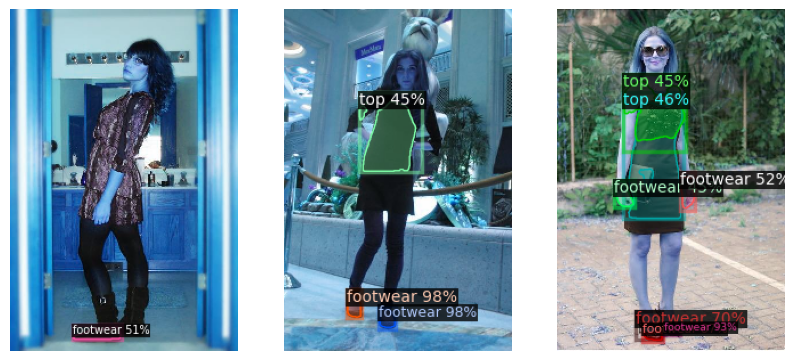

In [19]:
eval_tools.show_n(dataset_dicts=test_dataset_dicts, metadata=train_metadata, predictions = True)

In [20]:
mapping = {k: v for k, v in enumerate(train_metadata.thing_classes)}
mapping

{0: 'bag',
 1: 'dress',
 2: 'footwear',
 3: 'skirt',
 4: 'top',
 5: 'sunglasses',
 6: 'headwear',
 7: 'shorts',
 8: 'pants',
 9: 'belt',
 10: 'outer',
 11: 'scarf',
 12: 'boots'}

In [21]:
test_annots = eval_tools.createAnnots(test_dataset_dicts, mapping = mapping, sample_ratio=2)

100%|██████████| 5226/5226 [05:45<00:00, 15.13it/s]


In [23]:
# model_predictions = modanet_segmentation_dataset.create_annotation_set(
#     annotation_task = 'Instance Segmentation', name = 'exploration_preds_sampleratio2')

# modanet_segmentation_dataset.add_annotations(test_annots, annotation_set_id=model_predictions.id)

In [24]:
modanet_segmentation_dataset.view()

Open http://localhost:8123/datasets/1
